<h1 style="background-color:#FFDEAD;"><b>Porównanie wyników z testu matematycznego uczniów w wieku 15 lat dla wybranych krajów OECD na podstawie testu PISA w 2000r.</b></h1>
        
W projekcie skupiono się na wyborze kilku atrybutów i przeprowadzeniu analiz ich rozkładów jak i testów nieparametrycznych pomiędzy poszczególnymi cechami.
Wybór atrybutów jest subiektywny, nie poparty specjalistyczna wiedzą z zakresu pedagogiki.
Kryterium którym kierowano się w sposób szczególny był wybór atrybutów, dla których dostępne były pełne dane.
Dane dotyczące wyników testu przechowywane są w bazie sqlite.



<h1 style="background-color:#FFDEAD;">Wybór danych charakteryzujących kraje.</h1>

Na podstawie danych dostępnych w internecie pobrano następujace dane dotyczące poszczególnych krajów.
<ol><b>Produkt krajowy brutto(1)</b></ol>
<ol><b>% produktu krajowego brutto przeznaczanego na edukację(2)</b></ol>
<ol><b>Populację kraju(3)</b></ol>
<ol><b>Na podstawie zmiennych 1,2 obliczono przybliżoną kwotę wydawaną przez poszczególne kraje na edukację(4)</b></ol>

Dodanie zmiennej wyliczeniowej uzasadnia się łatwiejszym porównywaniem bezwzględnych wartości parametrów.

Poniższe fragmenty kodu prezentują import z pliku txt za pomocą pakietu pandas. Oraz ogólny preprocessing danych.


In [2]:

import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.graphics.gofplots import qqplot
import sqlite3
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import seaborn as sns
from openpyxl import Workbook
from openpyxl import load_workbook
from scipy.stats import shapiro

pop=pd.read_csv('gpb_population.txt',sep='\t',header=None)

pop.set_index(pop[0],inplace=True)
pop.index.rename('Kraje',inplace=True)
pop.drop(0,axis=1, inplace=True)
gpb=pd.read_csv('gpd_gpb.txt',header=None)
pop['gpb']=0
pop['gpb']=gpb[0].values


pop['gpb_to_education']=0
t_salaries=pd.read_csv('gpd_teachers_salary.txt',header=None)
pop['gpb_to_education']=t_salaries[0].values

pop.drop(['Slovak Republic','Slovenia','Turkey','Netherlands','Lithuania','Estonia','Colombia'
],axis=0,inplace=True)
pop.reset_index(inplace=True)

pop.rename(columns={"Kraje":"Country"},inplace=True)
pop.rename(columns={1:"PowierzchniaKraju"},inplace=True)





<h2>Przeprowadzono również klastrowanie metodą k-means. Zrezygnowano jednak z używania uzyskanych klastrów.</h2>

<AxesSubplot:xlabel='gpb', ylabel='PublicsSpendsOnEducation'>

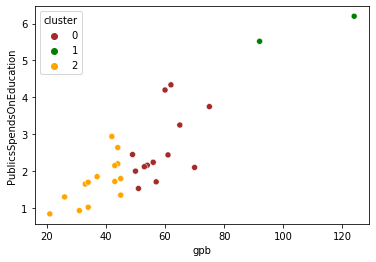

In [3]:
pop.gpb=pop.gpb.astype(int)
pop['gpb_to_education']=pop['gpb_to_education'].astype(int)
pop['PublicsSpendsOnEducation']=pop['gpb_to_education']*pop['gpb']/100
pop.describe()
k_means=KMeans(n_clusters=3)

model=k_means.fit(pop[['gpb','PublicsSpendsOnEducation']])
y_hat=k_means.predict(pop[['gpb','PublicsSpendsOnEducation']])

y_hat
pop['cluster']=0
pop['cluster']=y_hat
color=pop.index


color_dict = dict({0:'brown',
                  1:'green',
                  2: 'orange',
                  3: 'red'
                   })
sns.scatterplot(data=pop,x='gpb',y='PublicsSpendsOnEducation',hue='cluster',palette=color_dict)





<b>W kolejnym kroku zapisano wyniki testu PISA do bazy danych sqlite</b>

In [4]:
#reading excel files
conn=sqlite3.connect('Uczniowie_wyniki_std_errors.db')
c=conn.cursor()
wb=load_workbook('Wyniki_errors.xlsx')
sheet_names=wb.sheetnames


variable_dict={}
injection_statement=''



#create sql tables
def create_table(a,table_name):
    for s in a:
        if s=='Country':
            sql_querry=f'create table if not exists {table_name} ({s} TEXT'
        else:
            sql_querry=sql_querry+f',{s} INTEGER'
        
    sql_querry=f'{sql_querry})'    
    c.execute(sql_querry)
    
   
    insertion_statement=f'insert into {table_name} VALUES ('
    for licznik in range(len(a)):
        sql_insert=''
        df_ro=(a.loc[licznik])
        for k in df_ro:
            k=str(k)
            if sql_insert=='':
                sql_insert=f"\"{k}\""
            else:
                sql_insert=sql_insert+','+k
        insertion_statement=insertion_statement+sql_insert+')'
        
        c.execute(insertion_statement)
        conn.commit()
        insertion_statement=f'insert into {table_name} VALUES ('
        sql_insert=''
       
        
        
for a,k in enumerate(sheet_names):
    variable_dict[a]=k
    excel_data=pd.read_excel('Wyniki_errors.xlsx',sheet_name=k)
    excel_data.dropna(inplace=True)
    excel_data.round(1)
    
    
    excel_data.fillna(0,inplace=True)
    create_table(excel_data,k)
        

<b>Kolejny krok to ponowne pobranie danych z bazy sqlite</b>

In [5]:

conn=sqlite3.connect('Uczniowie_wyniki_std_errors.db')
c=conn.cursor()
#variable_dict={}
def table_names_from_db():
    sql='SELECT * FROM sqlite_master where type=\'table\''

    a=c.execute(sql)
    print(a)
    a=c.fetchall()
    for licznik in range(len(a)):
        table_name=a[licznik][1]
        variable_dict[licznik]=table_name
        from_sql_to_df(table_name,licznik)

def from_sql_to_df(table_name,licznik):
    
    sql=f'SELECT * FROM {table_name}'
    b=c.execute(sql)
    names=[description[0] for description in b.description]
    
    variable_dict[licznik]=pd.DataFrame(b,columns=names)
    variable_dict[licznik].drop_duplicates(inplace=True)
    variable_dict[licznik]['cluster']=pop['cluster']
    variable_dict[licznik].set_index('Country',inplace=True)
    
    
    
    
   
        

table_names_from_db()



<h1 style="background-color:#FFDEAD;"><b>Wykresy zależności</b></h1>

Poniższe wykresy pudełkowe narysowano w celu uzyksania zobrazowania zróżnicowania danych dotyczących poszczególnych krajów.
Pomimo faktu, że do analiz wzięto 30 państw z grupy OECD widoczne są istosne różnica pomiędzy wartościami produktu krajowego brutto.

Zmiana ustawienie wartości whiskers na poziom [15-85] pozwala na lepszą wizualizację poszczególnych zbiorów danych.

Mimo, że wykres pudełkowy dla wartości % pkb przekazywanego na edukację przez poszczególne kraje nie przedstawia
istotnego rozrzutu, to przeliczenie procentów na konkretne wartości bezwzględne uwidacznia tę różnicę.

W celu wartości dla poszczególnych krajów narysowany wykresy słupkowe.


Text(0.5, 1.0, '% PKB przekazywanego na edukację')

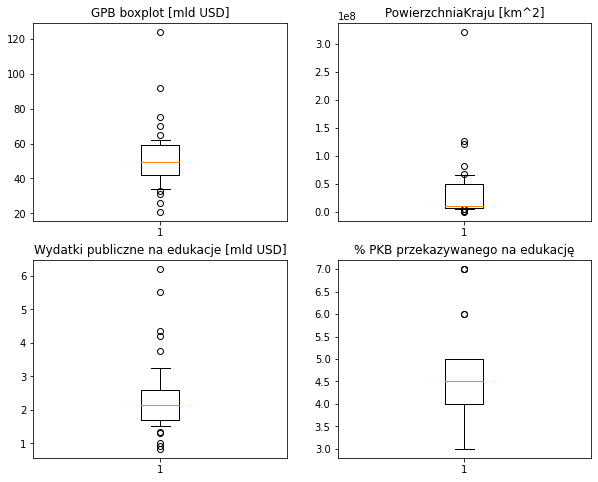

In [6]:
pop.describe()
fig, axs = plt.subplots(2,2,figsize=(10,8))

axs[0][0].boxplot(pop['gpb'],whis=[15, 85])
axs[0][0].set_title('GPB boxplot [mld USD]')

axs[0][1].boxplot(pop['PowierzchniaKraju'],whis=[15, 85])
axs[0][1].set_title('PowierzchniaKraju [km^2]')

axs[1][0].boxplot(pop['PublicsSpendsOnEducation'],whis=[15, 85])
axs[1][0].set_title('Wydatki publiczne na edukacje [mld USD]')

axs[1][1].boxplot(pop['gpb_to_education'],whis=[15, 85])
axs[1][1].set_title('% PKB przekazywanego na edukację')




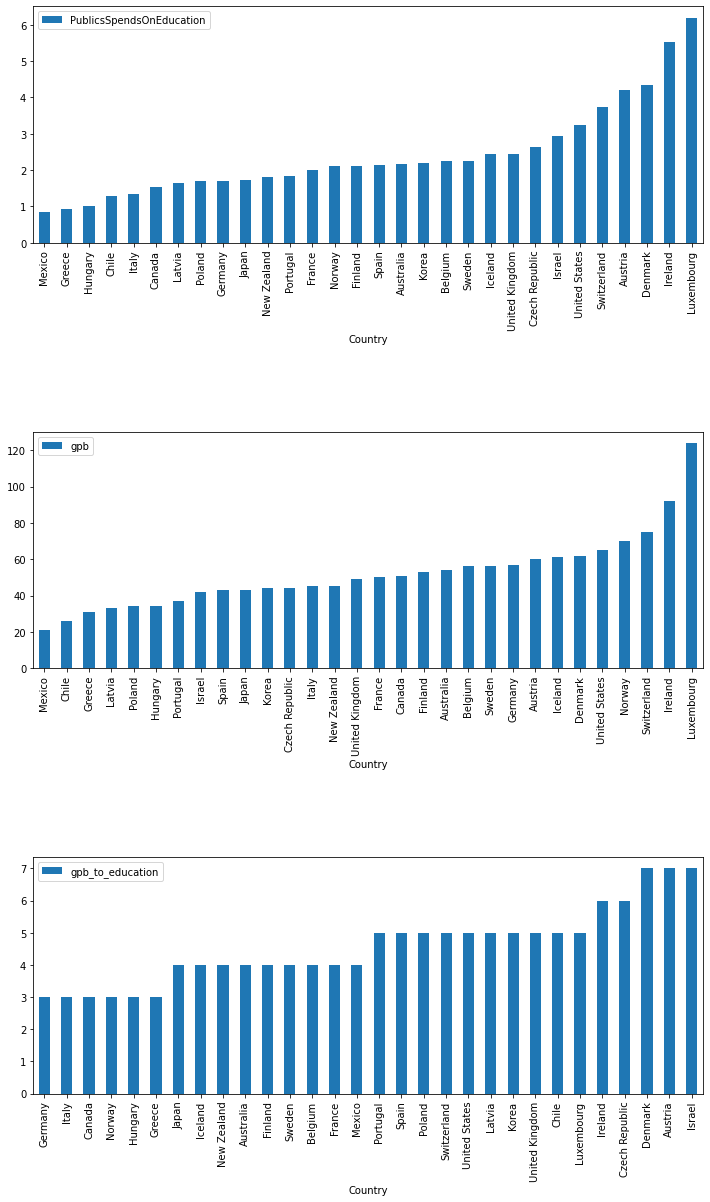

In [110]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,20),squeeze=True)

pop.sort_values(by='PublicsSpendsOnEducation').plot.bar(x='Country',y='PublicsSpendsOnEducation',ax=ax1, rot=90)

pop.sort_values(by='gpb').plot.bar(x='Country',y='gpb',ax=ax2)
pop.sort_values(by='gpb_to_education').plot.bar(x='Country',y='gpb_to_education',ax=ax3)

plt.subplots_adjust(hspace=0.8)

W kolejnym kroku przeprowadzono testy nieparametryczne odnośnie dopasowania rozkładów normalnego dla poszczególnych zmiennych.
Test shapiro dla produktu krajowego brutto pokazuje, że nie można założyć iż rozkład może być przybliżony rozkładem normalnym.


ShapiroResult(statistic=0.8773936629295349, pvalue=0.0024576454889029264)


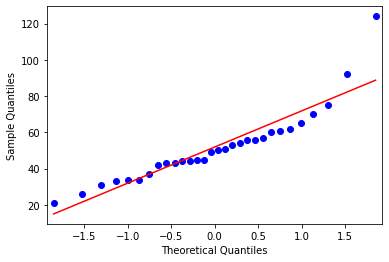

In [7]:
pop['gpb']
shapiro_test_1=shapiro(pop['gpb'])
qqplot(pop['gpb'].round(),line='s')

print(shapiro_test_1)

Wykreślono również średnie wyniki z testu z matematyki w funkcji produktu krajowego brutto.

Widoczna jest słaba relacja między pkb a wynikiem testu. Nie zdecydowano się jednak na obliczenie współczynnika korelacji pearsona, ponieważ jedna ze zmiennych nie podlega rozkładowi normalnemu.

Analogicznie postąpiono dla wartości zmiennej PublicsSpendsOnEducation - publiczne wydatki na edukację.

Text(0.5, 0, 'Produkt krajowy brutto [mld USD]')

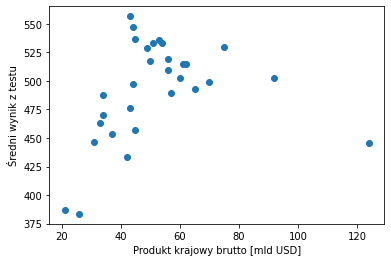

In [8]:
plt.scatter(pop['gpb'],variable_dict[0]['Average'])
plt.ylabel("Średni wynik z testu")
plt.xlabel("Produkt krajowy brutto [mld USD]")

Text(0.5, 0, 'Publiczne wydatki na edukację [mld USD]')

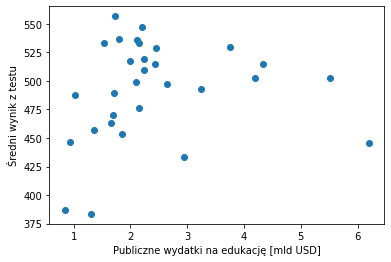

In [9]:
plt.scatter(pop['PublicsSpendsOnEducation'],variable_dict[0]['Average'])

shapiro(pop['PublicsSpendsOnEducation'])
plt.ylabel("Średni wynik z testu")
plt.xlabel("Publiczne wydatki na edukację [mld USD]")


                                    
<h1 style="background-color:#FFDEAD;">Testy parametryczne</h1>
    
Sposób przeprowadzenia testu PISA pozwala na przeprowadzenie testów odnośnie wartości średnich dla poszczególnych zmiennych.
T test przeprowadzony został dla poziomu istotności 5 %.
Hipotezą zerową H0 była hipoteza o równości średnich m1=m2
Hipoteza H1 zakładała m1>m2
Wartość True oznacza, że odrzucona została hipoteza H0.
W celach poglądowych wygenerowano również wykresy słupkowe poszczególnych zmiennych.
$$T = \frac{\bar{x1} -\bar{x2}}{\sqrt{\frac{s1^2}{n1}+\frac{s2^2}{n2}}}$$



In [10]:
import numpy as np
from scipy.stats import norm

i=1
variable_dict[1]

variable_dict[i]['T_stats']=(variable_dict[i]['AverageYes']-variable_dict[i]['AverageNo'])/np.sqrt(variable_dict[i]['StandardErrorYes']**2+variable_dict[i]['StandardErrorNO']**2)

variable_dict[i]
vals = norm.ppf([0.95])

variable_dict[i]['T_testResult']=variable_dict[i]['T_stats']>vals[0]





In [11]:
i=2
variable_dict[2]

variable_dict[2]['T_stats']=(variable_dict[2]['AverageYes']-variable_dict[2]['AverageNo'])/np.sqrt(variable_dict[2]['StandardErrorYes']**2+variable_dict[2]['StandardErrorNo']**2)

variable_dict[2]
vals = norm.ppf([0.95])

variable_dict[2]['T_testResult']=variable_dict[2]['T_stats']>vals[0]


In [12]:
i=3


variable_dict[i]['T_stats']=(variable_dict[i]['SeveralTimesWeek']-variable_dict[i]['FevTimes'])/np.sqrt(variable_dict[i]['StandardErrorFevTimes']**2+variable_dict[i]['StandardErrorSevTimes']**2)

variable_dict[i]
vals = norm.ppf([0.95])

variable_dict[i]['T_testResult']=(variable_dict[i]['T_stats'])>vals[0]
variable_dict[i]

variable_dict[i]['T_stats_2']=(variable_dict[i]['FevTimes']-variable_dict[i]['Never'])/np.sqrt(variable_dict[i]['StandardErrorNever']**2+variable_dict[i]['StandardErrorFevTimes']**2)

variable_dict[i]
vals = norm.ppf([0.95])

variable_dict[i]['T_testResult_2']=(variable_dict[i]['T_stats_2'])>vals[0]




Text(0.5, 1.0, 'Czy Twoi rodzice są imigrantami ?')

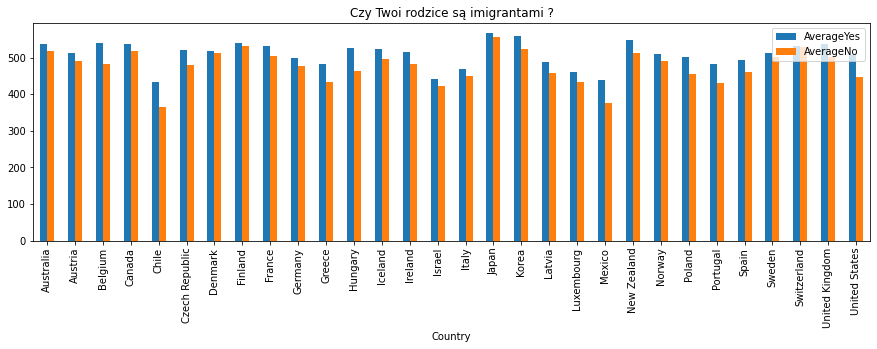

In [13]:
variable_dict[1][['AverageYes','AverageNo']].plot(kind='bar',figsize=(15,4))

plt.legend(loc='upper right')
plt.title('Czy Twoi rodzice są imigrantami ?')

Text(0.5, 1.0, 'Czy masz własne biurko do nauki ?')

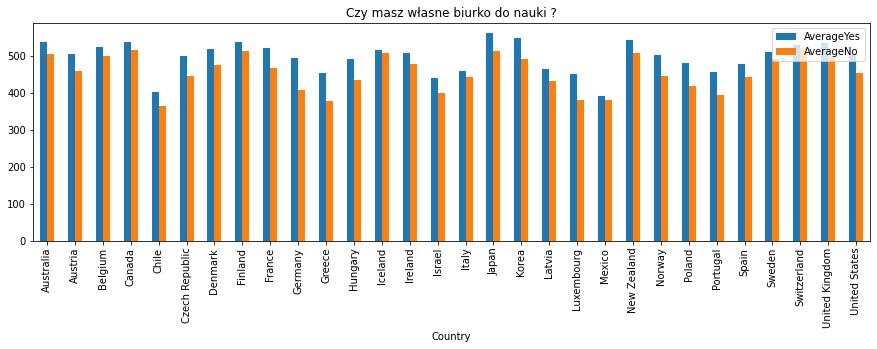

In [14]:
variable_dict[2][['AverageYes','AverageNo']].plot(kind='bar',figsize=(15,4))
plt.legend(loc='upper right')
plt.title('Czy masz własne biurko do nauki ?')

Text(0.5, 1.0, 'Jak często uczestniczysz w laboratoriach ?')

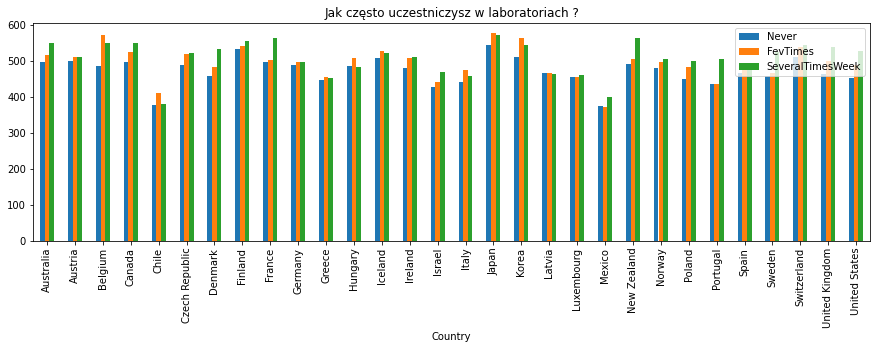

In [45]:
variable_dict[3][['Never','FevTimes','SeveralTimesWeek']].plot(kind='bar',figsize=(15,4),legend=True)

plt.legend(loc='upper right')
plt.title('Jak często uczestniczysz w laboratoriach ?')


Poniżej przedstawiono graficzną wizualizację wyników testu PISA z matematyki dla poszczególnych krajów.

In [16]:
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)





layout = dict(title='Pisa test result 2000', geo=dict(showframe=False, projection={'type': 'natural earth'}))

data = go.Choropleth(locations=variable_dict[0].index, locationmode='country names', z=variable_dict[0]['Average'].round(), colorscale='matter', colorbar={'title': '2000 Math result'})

fig = go.Figure(data=data, layout=layout)

iplot(fig)



Kolejne wizualizacje odnoszą się do testów parametrycznych poszczególnych zmiennych. Wartość True oznacza, że uzasadnionym jest twierdzenie, że uczniowie, którzy odpowiedzieli pozytywnie na pytanie uzyskali istotnie wyższe wyniki z testów.

In [17]:
import plotly.express as px
import pandas as pd

fig = px.choropleth(data_frame=variable_dict[1],
                    locations=variable_dict[1].index, 
                    locationmode="country names",
                    title='Czy Twoi rodzice urodzili się w kraju,w którym się uczysz ?',
                    color=variable_dict[1]['T_testResult'],
                    hover_data=variable_dict[1][["AverageYes", "AverageNo"]],
                    color_discrete_map={True:'Green',
                                        False:'Red'}
                                        
                    
                    
                   )
fig.show()




W 26 krajach z 30 na poziomie istotności 5 % można stwierdzić, że średnia uczniów, których rodzice urodzili się w kraju zamieszkania jest wyższa od dzieci imigrantów.

In [18]:
i=2
fig = px.choropleth(data_frame=variable_dict[i],
                    locations=variable_dict[i].index, 
                    locationmode="country names",
                    title='Czy posiadasz własne biurko do nauki ?',
                    color=variable_dict[i]['T_testResult'],
                    hover_data=variable_dict[i][["AverageYes", "AverageNo"]],
                    color_discrete_map={True:'Green',
                                        False:'Red'}
                                        
                    
                    
                   )
fig.show()




W 26 krajach z 30 na poziomie istotności 5 % można stwierdzić, że średnia uczniów,
którzy posiadają własne biurko do nauki jest wyższa niż uczniów, którzy nie posiadają własnego biurka.

In [19]:
i=3
variable_dict[3]
fig = px.choropleth(data_frame=variable_dict[i],
                    locations=variable_dict[i].index, 
                    locationmode="country names",
                    color=variable_dict[i]['T_testResult'],
                    title='Czy brak zajęć praktycznych wpływa negatywnie na wyniki testu ?',
                    hover_data=variable_dict[i][["Never", "FevTimes"]],
                    color_discrete_map={True:'Green',
                                        False:'Red'}
                                        
                    
                    
                   )
fig.show()


W 18 krajach z 30 na poziomie istotności 5 % można stwierdzić, że średnia uczniów,
którzy sporadycznie uczestniczą w zajęciach laboratoryjnych jest wyższa niż uczniów w nich nie uczestniczących.

In [20]:
i=3
variable_dict[3]
fig = px.choropleth(data_frame=variable_dict[i],
                    locations=variable_dict[i].index, 
                    locationmode="country names",
                    color=variable_dict[i]['T_testResult'],
                    title='Czy częste uczęszczanie na laboratoria pozwala na osiągnięcie lepszych wyników testu niż sporadyczne ?',
                    hover_data=variable_dict[i][["FevTimes", "SeveralTimesWeek"]],
                    color_discrete_map={True:'Green',
                                        False:'Red'}
                                        
                    
                    
                   )
fig.show()




W 10 krajach z 30 na poziomie istotności 5 % można stwierdzić, że średnia uczniów,
którzy regularnie uczestniczą w zajęciach laboratoryjnych jest wyższa niż uczniów w nich nie uczestniczących.

<h1 style="background-color:#FFDEAD;"><b>Podsumowanie</b></h1>

Metody zastosowane w eksperymencie uwidaczniają, różnicę miedzy wynikami testu z matematyki dla poszczególnych krajów.

Zależność miedzy produktem krajowym brutto a wynikami testu wydaje się być pozytywna. 
Przykład Luxemburgu pokazuję jednak, że mimo wysokiego pkb uczniowie nie osiągają spodziewanie wysokich wyników testu.
Może być to spowodowane specyficznymi uwarunkowaniami społecznymi występującymi w tym kraju.

Testowanie hipotezy o równości dwóch wartości przeciętnych pokazuje, że dla przeważającej ilości obserwacj:
<ol>-Dzieci imigrantów osiągają istotnie niższe wyniki od dzieci "rdzennych" mieszkańców danego kraju</ol>
<ol>-Własne biurko do nauki pomaga w osiaganiu lepszych wyników testów</ol>

W przypadku uczestnictwa w laboratoriach nie stwierdzono tak mocnych zależności pomiędzy porównaniami dla uczniów:
<ol>-Nie uczestniczących w laboratoriach w porównaniu z uczestniczącymi sporadycznie</ol>
<ol>-Uczestniczących w laboratoriach regularnie w porównaniu z uczestniczącymi sporadycznie</ol>


Źródła danych:
<ol>1.https://www.oecd.org/pisa/test/</ol>
<ol>2.data.worldbank.org</ol>
